In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import json

In [4]:
##define the data folder path
folder_path = './data/question_1b'
file_type = ".json"

with open(f'{folder_path}/appliance_params{file_type}', 'r') as f:
    appliance_params = json.load(f)

with open(f'{folder_path}/bus_params{file_type}', 'r') as f:
    bus_params = json.load(f)

with open(f'{folder_path}/consumer_params{file_type}', 'r') as f:
    consumer_params = json.load(f)

with open(f'{folder_path}/DER_production{file_type}', 'r') as f:
    DER_production = json.load(f)

with open(f'{folder_path}/usage_preferences{file_type}', 'r') as f:
    usage_preference = json.load(f)


In [5]:
# System Parameters
bus_data = bus_params[0]
tau_imp = bus_data['import_tariff_DKK/kWh']
tau_exp = bus_data['export_tariff_DKK/kWh']
max_import = bus_data['max_import_kW']
max_export = bus_data['max_export_kW']
electricity_prices = bus_data['energy_price_DKK_per_kWh']

In [6]:
##PV parameters
pv_data = appliance_params['DER'][0]
pv_max_power = pv_data['max_power_kW']
pv_profile = DER_production[0]['hourly_profile_ratio']
pv_prod_hourly = [pv_max_power * ratio for ratio in pv_profile] #PV production per hour (kW)

In [7]:
#load parameters
load_data = appliance_params['load'][0]
D_max = load_data['max_load_kWh_per_hour'] #Maximum power consumption
D_ref_ratio = usage_preference[0]['load_preferences'][0]['hourly_profile_ratio'] #Minimum daily consumption
D_ref = [D_max * ratio for ratio in D_ref_ratio] # reference load profile

In [8]:
## Temporal parameters
T = len(electricity_prices)  #24 hours
Times = range(T)
#Discomfort parameter
alpha = 0.5

In [9]:
model = gp.Model("Energy_Optimization")

##Decision variables:
D_t = model.addVars(Times, lb=0, ub=D_max, name="D_t")  #Load consumption (kW)
C_t = model.addVars(Times, lb=0, name="C_t")  # Energy curtailed from PV
P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")  #Grid import (kW)
P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")  # Grid export (kW)
L_t = model.addVars(Times, lb=0, name="L_t")  #Discomfort


Set parameter Username
Set parameter LicenseID to value 2617496
Academic license - for non-commercial use only - expires 2026-02-03
Set parameter LicenseID to value 2617496
Academic license - for non-commercial use only - expires 2026-02-03


## Mathematical Formulation

### Objective Function

$$
\min \sum_{t \in T} \left[ P_{imp,t} \cdot (\tau_{imp} + \lambda_t) - P_{exp,t} \cdot (\lambda_t - \tau_{exp}) \right] + \alpha \sum_{t \in T} L_t
$$

Where:
- $P_{imp,t}$: Grid import at time $t$ (kW)
- $P_{exp,t}$: Grid export at time $t$ (kW)
- $\tau_{imp}$: Import tariff (DKK/kWh)
- $\tau_{exp}$: Export tariff (DKK/kWh)
- $\lambda_t$: Electricity price at time $t$ (DKK/kWh)
- $L_t$: Discomfort at time $t$ (kW)
- $\alpha$: Discomfort penalty parameter (DKK/kW)

### Decision Variables

- $D_t \in [0, L_{max}]$: Load consumption at time $t$ (kW)
- $C_t \geq 0$: PV curtailment at time $t$ (kW)
- $P_{imp,t} \in [0, P_{imp,max}]$: Grid import at time $t$ (kW)
- $P_{exp,t} \in [0, P_{exp,max}]$: Grid export at time $t$ (kW)
- $L_t \geq 0$: Discomfort at time $t$ (kW)

### Constraints

**1. Power Balance:**
$$P_{imp,t} - P_{exp,t} = D_t - P^{PV}_t + C_t, \quad \forall t \in T$$

**2. PV Curtailment Limit:**
$$C_t \leq P^{PV}_t, \quad \forall t \in T$$

**3. Discomfort (Absolute Deviation):**
$$L_t \geq D_t - D_{ref,t}, \quad \forall t \in T$$
$$L_t \geq -(D_t - D_{ref,t}), \quad \forall t \in T$$

**4. Daily Energy Constraint:**
$$\sum_{t \in T} D_t = \sum_{t \in T} D_{ref,t}$$

**5. Variable Bounds:**
- $0 \leq D_t \leq D_{max}$
- $0 \leq P_{imp,t} \leq P_{imp,max}$
- $0 \leq P_{exp,t} \leq P_{exp,max}$
- $C_t, L_t \geq 0$

### Notes
- This is an **LP formulation** (binary import/export constraints omitted)
- The discomfort term $L_t$ captures deviations from the reference load profile $D_{ref,t}$
- The parameter $\alpha$ controls the trade-off between cost minimization and comfort maximization

In [10]:
## Objective function
#Minimize: Import Cost - Export Revenue + Discomfort Penalty
#Import Cost = P_imp * (tau_imp + price)
# Export Revenue = P_exp * (price - tau_exp)
#Discomfort Penalty = alpha * sum(L_t)
model.setObjective(
    gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                P_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
    alpha * gp.quicksum(L_t[t] for t in Times),
    GRB.MINIMIZE)

In [11]:
#Add constraints

##Curtailment constraint - Cannot curtail more than PV produces
Curtailment_constraint = [
	model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
	for t in Times
]

##Discomfort constraints: D_t >= |L_t - L_ref[t]|
discomfort_constraint_1 = [
	model.addLConstr(L_t[t] >= D_t[t] - D_ref[t], name=f"discomfort_1_{t}")
	for t in Times
]

discomfort_constraint_2 = [
	model.addLConstr(L_t[t] >= -(D_t[t] - D_ref[t]), name=f"discomfort_2_{t}")
	for t in Times
]

#power balance constraint
power_balance_constraint = [
	model.addLConstr(P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly[t] + C_t[t], name=f"power_balance_{t}")
	for t in Times
]
# daily energy constraint
model.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref), 
    name="daily_energy_constraint")

<gurobi.Constr *Awaiting Model Update*>

In [12]:
##Solve optimization problem
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 97 rows, 120 columns and 240 nonzeros
Model fingerprint: 0x75ac1c4f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 3e+00]
  Bounds range     [3e+00, 1e+03]
  RHS range        [1e-01, 3e+01]
Presolve removed 33 rows and 42 columns
Presolve time: 0.00s
Presolved: 64 rows, 78 columns, 165 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -7.0800000e+03   2.896398e+04   0.000000e+00      0s

CPU model: AMD Ryzen 7 6800HS Creator Edition, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 97 rows, 120 columns and 240 nonzeros
Model fingerprint: 0x75ac1c4f
Coefficient statistics:
 

In [13]:
# print results
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    print(f"Total cost: {model.objVal:.2f} DKK")
    print("Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)")
    for t in Times:
        print(f"{t:4d} | {D_t[t].X:9.2f} | {C_t[t].X:15.2f} | {P_imp_t[t].X:15.2f} | {P_exp_t[t].X:15.2f} | {pv_prod_hourly[t]:18.2f} | {electricity_prices[t]:25.2f}")


Optimal solution found:
Total cost: 29.25 DKK
Hour | Load (kW) | Curtailment (kW) | Grid Import (kW) | Grid Export (kW) | PV Production (kW) | Electricity Price (DKK/kWh)
   0 |      0.17 |            0.00 |            0.17 |            0.00 |               0.00 |                      1.10
   1 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      1.05
   2 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      1.00
   3 |      0.12 |            0.00 |            0.12 |            0.00 |               0.00 |                      0.90
   4 |      1.17 |            0.00 |            1.17 |            0.00 |               0.00 |                      0.85
   5 |      1.44 |            0.00 |            1.29 |            0.00 |               0.15 |                      1.01
   6 |      2.28 |            0.00 |            1.86 |            0.00 |               0.42 |               

# Dual Problem Analysis - Strong Duality Verification



In [14]:
##Strong Duality Verification
primal_obj = model.objVal
dual_bound = model.ObjBound
diff = abs(primal_obj - dual_bound)

print(f"{'Primal Objective (DKK)':>30} : {primal_obj:>20.6f}")
print(f"{'Dual Bound (DKK)':>30} : {dual_bound:>20.6f}")
print(f"{'Difference':>30} : {diff:>20.10f}")

        Primal Objective (DKK) :            29.246400
              Dual Bound (DKK) :            29.246400
                    Difference :         0.0000000000


# Part 1: Flexibility Parameter Sweep (α Sensitivity Analysis)

**Objective**: Analyze how the discomfort penalty α affects the cost-comfort trade-off

**Approach**: 
- Test α values from very low (highly flexible) to very high (highly inflexible)
- For each α, solve optimization and track cost vs. discomfort
- Constraint: Daily energy must equal sum(L_ref)

**Expected Result**: Trade-off curve showing that lower α (more flexibility) reduces cost but increases discomfort, while higher α (less flexibility) increases cost but reduces discomfort

In [15]:
#Function to run optimization with different alpha values
def run_alpha_sensitivity(alpha_values, pv_prod_hourly, D_ref, electricity_prices, 
                          tau_imp, tau_exp, max_import, max_export, D_max):
    """
    Run optimization for different alpha values and return results
    """
    results = []
    
    for alpha in alpha_values:
        ##Create model
        model = gp.Model("Energy_Optimization_Alpha_Sweep")
        model.setParam('OutputFlag', 0)  #Suppress output
        
        Times = range(len(electricity_prices))
        
        #Decision variables
        D_t = model.addVars(Times, lb=0, ub=D_max, name="D_t")
        C_t = model.addVars(Times, lb=0, name="C_t")
        P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")
        P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")
        L_t = model.addVars(Times, lb=0, name="L_t")
        
        ## Objective function with current alpha
        model.setObjective(
            gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                        P_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
            alpha * gp.quicksum(L_t[t] for t in Times),
            GRB.MINIMIZE)
        
        #Constraints
        for t in Times:
            model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
            model.addLConstr(L_t[t] >= D_t[t] - D_ref[t], name=f"discomfort_1_{t}")
            model.addLConstr(L_t[t] >= -(D_t[t] - D_ref[t]), name=f"discomfort_2_{t}")
            model.addLConstr(P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly[t] + C_t[t], 
                           name=f"power_balance_{t}")
        
        # daily energy constraint
        model.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref), 
                        name="daily_energy_constraint")
        
        #Solve
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            # Calculate metrics
            total_cost = sum(P_imp_t[t].X * (tau_imp + electricity_prices[t]) - 
                           P_exp_t[t].X * (electricity_prices[t] - tau_exp) for t in Times)
            total_discomfort = sum(L_t[t].X for t in Times)
            total_load = sum(D_t[t].X for t in Times)
            total_import = sum(P_imp_t[t].X for t in Times)
            total_export = sum(P_exp_t[t].X for t in Times)
            
            results.append({
                'alpha': alpha,
                'total_cost': total_cost,
                'total_discomfort': total_discomfort,
                'objective_value': model.objVal,
                'total_load': total_load,
                'total_import': total_import,
                'total_export': total_export,
                'load_profile': [D_t[t].X for t in Times]
            })
        else:
            print(f"Warning: No optimal solution for alpha={alpha}")
    
    return results


In [16]:
# Run alpha sensitivity analysis
alpha_values = [round(x * 0.2, 1) for x in range(0, 11)]  # 0.0, 0.2, 0.4, ..., 1.8, 2.0

print("Running alpha sensitivity analysis...")
alpha_results = run_alpha_sensitivity(
    alpha_values, pv_prod_hourly, D_ref, electricity_prices,
    tau_imp, tau_exp, max_import, max_export, D_max
)

print("\nSummary:")
print(f"{'Alpha':<10} {'Cost (DKK)':<15} {'Discomfort':<15} {'Objective':<15}")
print("-" * 55)
for result in alpha_results:
    print(f"{result['alpha']:<10} {result['total_cost']:<15.2f} {result['total_discomfort']:<15.2f} {result['objective_value']:<15.2f}")

Running alpha sensitivity analysis...

Summary:
Alpha      Cost (DKK)      Discomfort      Objective      
-------------------------------------------------------
0.0        20.34           33.21           20.34          
0.2        21.33           20.28           25.39          
0.4        24.51           9.51            28.32          
0.6        24.94           8.61            30.11          
0.8        26.12           6.72            31.50          
1.0        28.55           4.23            32.78          
1.2        32.82           0.60            33.54          
1.4        33.55           0.00            33.55          
1.6        33.55           0.00            33.55          
1.8        33.55           0.00            33.55          
2.0        33.55           0.00            33.55          


Saved: ./Plots/Scenarios b/alpha_sensitivity.png


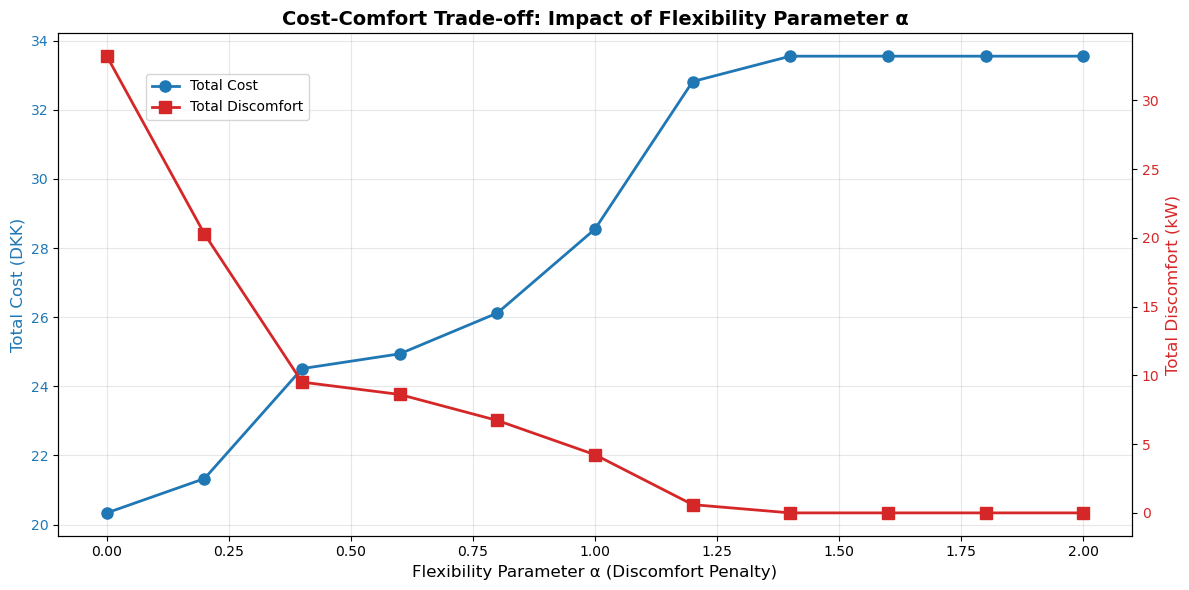


Key Insights:
- Most flexible (α=0.0): Cost = 20.34 DKK, Discomfort = 33.21 kW
- Mid-range (α=1.0): Cost = 28.55 DKK, Discomfort = 4.23 kW
- Least flexible (α=2.0): Cost = 33.55 DKK, Discomfort = 0.00 kW


In [17]:
##Plot alpha sensitivity results
fig, ax1 = plt.subplots(figsize=(12, 6))

#Extract data
alphas = [r['alpha'] for r in alpha_results]
costs = [r['total_cost'] for r in alpha_results]
discomforts = [r['total_discomfort'] for r in alpha_results]

# plot cost on left axis
color = 'tab:blue'
ax1.set_xlabel('Flexibility Parameter α (Discomfort Penalty)', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', color=color, fontsize=12)
ax1.plot(alphas, costs, marker='o', color=color, linewidth=2, markersize=8, label='Total Cost')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

##plot discomfort on right axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Discomfort (kW)', color=color, fontsize=12)
ax2.plot(alphas, discomforts, marker='s', color=color, linewidth=2, markersize=8, label='Total Discomfort')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title('Cost-Comfort Trade-off: Impact of Flexibility Parameter α', fontsize=14, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88), fontsize=10)
fig.tight_layout()

# Save plot
import os
os.makedirs('./Plots/Scenarios b/', exist_ok=True)
plt.savefig('./Plots/Scenarios b/alpha_sensitivity.png', dpi=300, bbox_inches='tight')
print("Saved: ./Plots/Scenarios b/alpha_sensitivity.png")

plt.show()

print("\nKey Insights:")
print(f"- Most flexible (α={alphas[0]}): Cost = {costs[0]:.2f} DKK, Discomfort = {discomforts[0]:.2f} kW")
print(f"- Mid-range (α={alphas[len(alphas)//2]}): Cost = {costs[len(costs)//2]:.2f} DKK, Discomfort = {discomforts[len(discomforts)//2]:.2f} kW")
print(f"- Least flexible (α={alphas[-1]}): Cost = {costs[-1]:.2f} DKK, Discomfort = {discomforts[-1]:.2f} kW")

# Part 2: Load Flexibility Scenarios (α = 0.5 fixed)

**Objective**: Compare how different levels of physical load flexibility impact optimization results

**Scenarios** (from most to least flexible):

1. **Scenario 1: 100% Flexible**
   - Constraint: Only `sum(D_t) = sum(D_ref)` (daily total)

2. **Scenario 2: 50% Flexible**
   - Constraint: `D_t[t] ≥ 0.5 × D_ref[t]` + daily total

3. **Scenario 3: 30% Flexible**
   - Constraint: `D_t[t] ≥ 0.7 × D_ref[t]` + daily total

4. **Scenario 4: 10% Flexible**
   - Constraint: `D_t[t] ≥ 0.9 × D_ref[t]` + daily total

5. **Scenario 5: 0% Flexible (Rigid)**
   - Constraint: `D_t[t] = D_ref[t]` (fixed)

**Fixed Parameters**: α = 0.5, daily energy = sum(D_ref)

In [18]:
##Function to run optimization with different flexibility constraints
def run_flexibility_scenario(scenario_name, flexibility_pct, alpha, pv_prod_hourly, D_ref, 
                             electricity_prices, tau_imp, tau_exp, max_import, max_export, D_max):
    """
    Run optimization with flexibility constraints
    flexibility_pct: 1.0 = fully flexible, 0.5 = 50% flexible, 0.0 = fully rigid
    """
    model = gp.Model(f"Energy_Optimization_{scenario_name}")
    model.setParam('OutputFlag', 0)
    
    Times = range(len(electricity_prices))
    
    #decision variables
    D_t = model.addVars(Times, lb=0, ub=D_max, name="D_t")
    C_t = model.addVars(Times, lb=0, name="C_t")
    P_imp_t = model.addVars(Times, lb=0, ub=max_import, name="P_imp_t")
    P_exp_t = model.addVars(Times, lb=0, ub=max_export, name="P_exp_t")
    L_t = model.addVars(Times, lb=0, name="L_t")
    
    ##Objective function
    model.setObjective(
        gp.quicksum(P_imp_t[t] * (tau_imp + electricity_prices[t]) - 
                    P_exp_t[t] * (electricity_prices[t] - tau_exp) for t in Times) + 
        alpha * gp.quicksum(L_t[t] for t in Times),
        GRB.MINIMIZE)
    
    # standard constraints
    for t in Times:
        model.addLConstr(C_t[t] <= pv_prod_hourly[t], name=f"Curtailment_{t}")
        model.addLConstr(L_t[t] >= D_t[t] - D_ref[t], name=f"discomfort_1_{t}")
        model.addLConstr(L_t[t] >= -(D_t[t] - D_ref[t]), name=f"discomfort_2_{t}")
        model.addLConstr(P_imp_t[t] - P_exp_t[t] == D_t[t] - pv_prod_hourly[t] + C_t[t], 
                       name=f"power_balance_{t}")
        
        ##Flexibility constraint
        if flexibility_pct == 0.0:  # Fully rigid
            model.addLConstr(D_t[t] == D_ref[t], name=f"rigid_load_{t}")
        elif flexibility_pct < 1.0:  # Partial flexibility
            min_load = (1.0 - flexibility_pct) * D_ref[t]
            model.addLConstr(D_t[t] >= min_load, name=f"min_load_{t}")
    
    # Daily energy constraint
    model.addLConstr(gp.quicksum(D_t[t] for t in Times) == sum(D_ref), 
                    name="daily_energy_constraint")
    
    # Solve
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        # Calculate metrics
        total_cost = sum(P_imp_t[t].X * (tau_imp + electricity_prices[t]) - 
                       P_exp_t[t].X * (electricity_prices[t] - tau_exp) for t in Times)
        total_discomfort = sum(L_t[t].X for t in Times)
        total_load = sum(D_t[t].X for t in Times)
        total_import = sum(P_imp_t[t].X for t in Times)
        total_export = sum(P_exp_t[t].X for t in Times)
        
        return {
            'scenario': scenario_name,
            'flexibility_pct': flexibility_pct,
            'total_cost': total_cost,
            'total_discomfort': total_discomfort,
            'objective_value': model.objVal,
            'total_load': total_load,
            'total_import': total_import,
            'total_export': total_export,
            'load_profile': [D_t[t].X for t in Times],
            'curtailment': [C_t[t].X for t in Times],
            'grid_import': [P_imp_t[t].X for t in Times],
            'grid_export': [P_exp_t[t].X for t in Times]
        }
    else:
        print(f"Warning: No optimal solution for {scenario_name}")
        return None


In [19]:
# Run flexibility scenarios for multiple alpha values
scenarios = [
    ("Scenario 1: 100% Flexible", 1.0),
    ("Scenario 2: 50% Flexible", 0.5),
    ("Scenario 3: 30% Flexible", 0.3),
    ("Scenario 4: 10% Flexible", 0.1),
    ("Scenario 5: 0% Flexible (Rigid)", 0.0)
]

alpha_values_flex = [0.0, 0.2, 0.5, 0.8, 1.0, 1.2]
all_results = {}

for alpha_val in alpha_values_flex:
    print(f"\n{'='*70}")
    print(f"Running flexibility scenarios with α = {alpha_val}...")
    print(f"{'='*70}")
    
    scenario_results_alpha = []
    
    for scenario_name, flexibility in scenarios:
        print(f"\nSolving {scenario_name} (α={alpha_val})...")
        result = run_flexibility_scenario(
            scenario_name, flexibility, alpha_val, pv_prod_hourly, D_ref,
            electricity_prices, tau_imp, tau_exp, max_import, max_export, D_max
        )
        if result:
            result['alpha'] = alpha_val  # Add alpha to result
            scenario_results_alpha.append(result)
            print(f"  ✓ Cost: {result['total_cost']:.2f} DKK, Discomfort: {result['total_discomfort']:.2f} kW")
    
    all_results[alpha_val] = scenario_results_alpha
    
    # Print summary for this alpha
    print(f"\n{'='*70}")
    print(f"FLEXIBILITY SCENARIOS SUMMARY (α = {alpha_val})")
    print(f"{'='*70}")
    print(f"{'Scenario':<35} {'Cost (DKK)':<15} {'Discomfort':<15} {'Objective':<15}")
    print("-" * 70)
    for result in scenario_results_alpha:
        print(f"{result['scenario']:<35} {result['total_cost']:<15.2f} {result['total_discomfort']:<15.2f} {result['objective_value']:<15.2f}")

# Store the α=0.5 results as the default for backward compatibility with existing plots
scenario_results = all_results[0.5]



Running flexibility scenarios with α = 0.0...

Solving Scenario 1: 100% Flexible (α=0.0)...


  ✓ Cost: 20.34 DKK, Discomfort: 33.21 kW

Solving Scenario 2: 50% Flexible (α=0.0)...
  ✓ Cost: 23.98 DKK, Discomfort: 22.23 kW

Solving Scenario 3: 30% Flexible (α=0.0)...
  ✓ Cost: 26.52 DKK, Discomfort: 14.47 kW

Solving Scenario 4: 10% Flexible (α=0.0)...
  ✓ Cost: 30.14 DKK, Discomfort: 4.97 kW

Solving Scenario 5: 0% Flexible (Rigid) (α=0.0)...
  ✓ Cost: 33.55 DKK, Discomfort: 0.00 kW

FLEXIBILITY SCENARIOS SUMMARY (α = 0.0)
Scenario                            Cost (DKK)      Discomfort      Objective      
----------------------------------------------------------------------
Scenario 1: 100% Flexible           20.34           33.21           20.34          
Scenario 2: 50% Flexible            23.98           22.23           23.98          
Scenario 3: 30% Flexible            26.52           14.47           26.52          
Scenario 4: 10% Flexible            30.14           4.97            30.14          
Scenario 5: 0% Flexible (Rigid)     33.55           0.00            33.55

Saved: ./Plots/Scenarios b/load_profiles_comparison.png


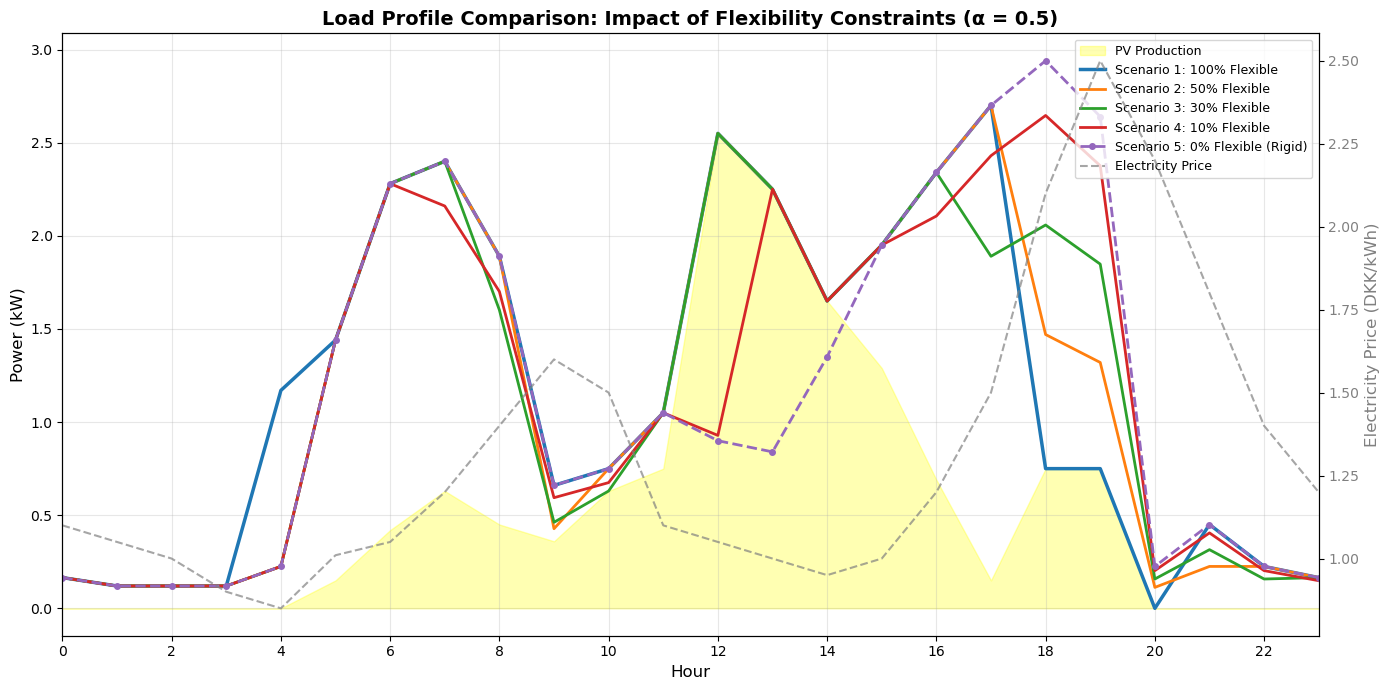


Key Observations:
- Scenario 1 (100% Flexible): Maximum load shifting to avoid high-price hours
- Scenario 5 (0% Flexible): Follows reference profile exactly, no optimization
- Partial flexibility scenarios show progressive constraint on load shifting


In [20]:
# Plot Load Profiles Comparison - All scenarios on one plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot PV production as yellow semi-transparent area
hours = range(24)
ax.fill_between(hours, 0, pv_prod_hourly, alpha=0.3, color='yellow', label='PV Production')

# Define colors for each scenario
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
line_styles = ['-', '-', '-', '-', '--']

# Plot load profiles for each scenario
for i, result in enumerate(scenario_results):
    ax.plot(hours, result['load_profile'], 
           color=colors[i], 
           linestyle=line_styles[i],
           linewidth=2.5 if i == 0 else 2,
           marker='o' if i == len(scenario_results)-1 else None,
           markersize=4,
           label=result['scenario'])

ax.set_xlabel('Hour', fontsize=12)
ax.set_ylabel('Power (kW)', fontsize=12)
ax.set_title('Load Profile Comparison: Impact of Flexibility Constraints (α = 0.5)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 23)
ax.set_xticks(range(0, 24, 2))

# Add electricity prices on secondary y-axis
ax2 = ax.twinx()
ax2.plot(hours, electricity_prices, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Electricity Price')
ax2.set_ylabel('Electricity Price (DKK/kWh)', fontsize=12, color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Combine legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

plt.tight_layout()

# Save plot
import os
os.makedirs('./Plots/Scenarios b/', exist_ok=True)
plt.savefig('./Plots/Scenarios b/load_profiles_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: ./Plots/Scenarios b/load_profiles_comparison.png")

plt.show()

print("\nKey Observations:")
print(f"- Scenario 1 (100% Flexible): Maximum load shifting to avoid high-price hours")
print(f"- Scenario 5 (0% Flexible): Follows reference profile exactly, no optimization")
print(f"- Partial flexibility scenarios show progressive constraint on load shifting")

Saved: ./Plots/Scenarios b/cost_discomfort_comparison.png


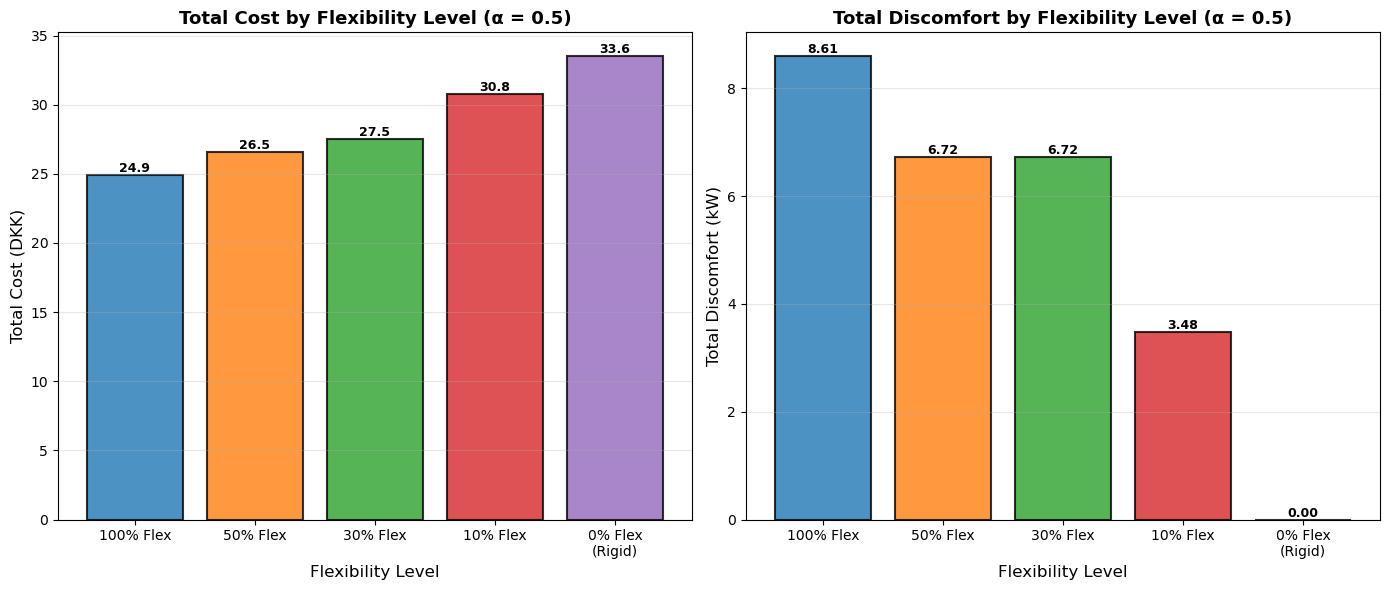


Cost Savings vs. Fully Rigid Scenario:
  Scenario 1: 100% Flexible          :   8.61 DKK (25.67% reduction)
  Scenario 2: 50% Flexible           :   7.01 DKK (20.89% reduction)
  Scenario 3: 30% Flexible           :   6.03 DKK (17.97% reduction)
  Scenario 4: 10% Flexible           :   2.76 DKK ( 8.21% reduction)


In [21]:
# Plot Cost & Discomfort Comparison Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Extract data and create clearer labels
scenario_labels = ['100% Flex', '50% Flex', '30% Flex', '10% Flex', '0% Flex\n(Rigid)']
costs = [r['total_cost'] for r in scenario_results]
discomforts = [r['total_discomfort'] for r in scenario_results]

x_pos = np.arange(len(scenario_labels))

# Plot costs
bars1 = ax1.bar(x_pos, costs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Flexibility Level', fontsize=12)
ax1.set_ylabel('Total Cost (DKK)', fontsize=12)
ax1.set_title('Total Cost by Flexibility Level (α = 0.5)', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenario_labels, fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot discomforts
bars2 = ax2.bar(x_pos, discomforts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Flexibility Level', fontsize=12)
ax2.set_ylabel('Total Discomfort (kW)', fontsize=12)
ax2.set_title('Total Discomfort by Flexibility Level (α = 0.5)', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scenario_labels, fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()

# Save plot
import os
os.makedirs('./Plots/Scenarios b/', exist_ok=True)
plt.savefig('./Plots/Scenarios b/cost_discomfort_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: ./Plots/Scenarios b/cost_discomfort_comparison.png")

plt.show()

# Calculate savings vs fully rigid
rigid_cost = scenario_results[-1]['total_cost']
print("\nCost Savings vs. Fully Rigid Scenario:")
for result in scenario_results[:-1]:
    savings = rigid_cost - result['total_cost']
    savings_pct = (savings / rigid_cost) * 100
    print(f"  {result['scenario']:<35}: {savings:>6.2f} DKK ({savings_pct:>5.2f}% reduction)")

Saved: ./Plots/Scenarios b/pareto_frontier_multi_alpha.png


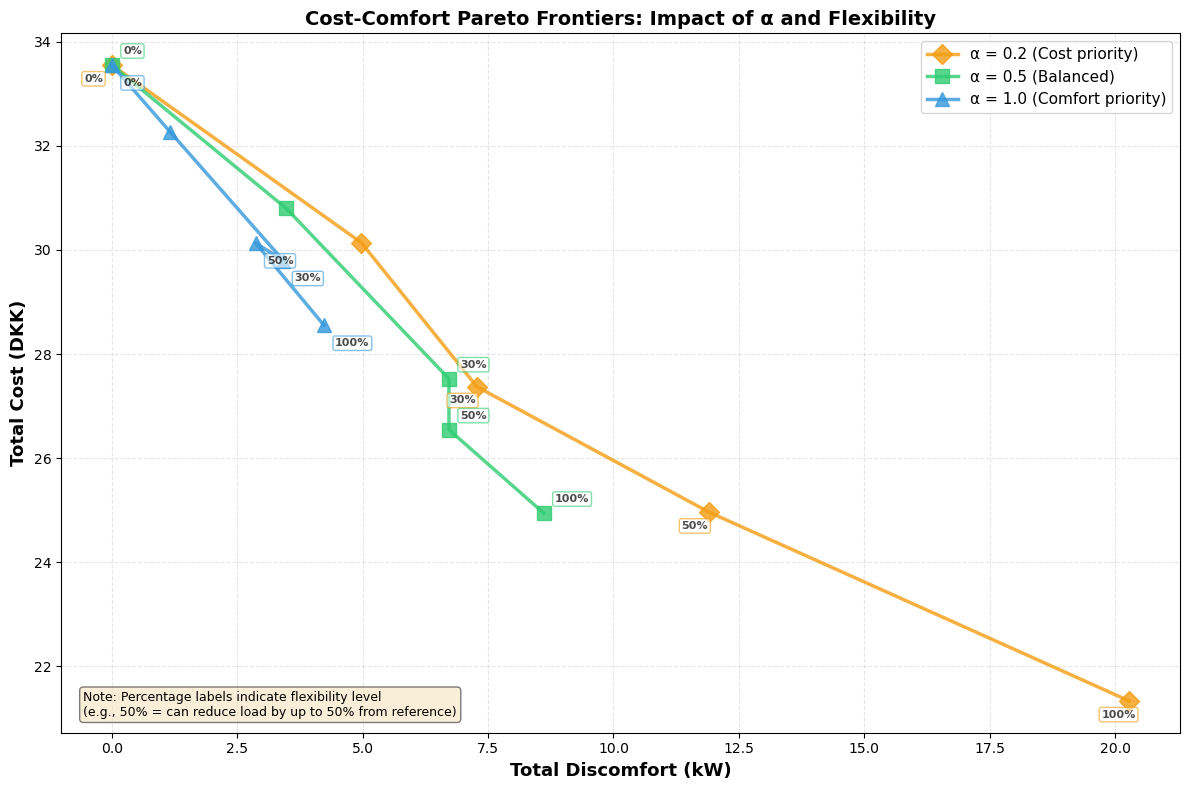


Pareto Frontier Analysis Across Alpha Values:

α = 0.2 (α = 0.2 (Cost priority)):
  Cost range (0% to 100% flex): 12.22 DKK (36.4% reduction)
  Discomfort range: 20.28 kW
  Cost/Discomfort trade-off ratio: 0.60 DKK/kW

α = 0.5 (α = 0.5 (Balanced)):
  Cost range (0% to 100% flex): 8.61 DKK (25.7% reduction)
  Discomfort range: 8.61 kW
  Cost/Discomfort trade-off ratio: 1.00 DKK/kW

α = 1.0 (α = 1.0 (Comfort priority)):
  Cost range (0% to 100% flex): 5.00 DKK (14.9% reduction)
  Discomfort range: 4.23 kW
  Cost/Discomfort trade-off ratio: 1.18 DKK/kW


In [22]:
# Plot: Cost-Discomfort Trade-off (Pareto Frontier) with Multiple Alpha Values
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and markers for different alpha values (plotting 0.2, 0.5, 1.0)
alpha_colors = {0.2: '#f39c12', 0.5: '#2ecc71', 1.0: '#3498db'}
alpha_markers = {0.2: 'D', 0.5: 's', 1.0: '^'}
alpha_labels = {0.2: 'α = 0.2 (Cost priority)', 0.5: 'α = 0.5 (Balanced)', 1.0: 'α = 1.0 (Comfort priority)'}

# Plot alpha values 0.2, 0.5, and 1.0
alphas_to_plot = [0.2, 0.5, 1.0]

for alpha_val in alphas_to_plot:
    if alpha_val in all_results:
        results = all_results[alpha_val]
        
        # Extract data
        discomforts = [r['total_discomfort'] for r in results]
        costs = [r['total_cost'] for r in results]
        flexibility_pcts = [r['flexibility_pct'] for r in results]
        
        # Plot line connecting points
        ax.plot(discomforts, costs, 
               color=alpha_colors[alpha_val],
               linewidth=2.5, 
               marker=alpha_markers[alpha_val],
               markersize=10, 
               alpha=0.8, 
               label=alpha_labels[alpha_val])
        
        # Annotate flexibility percentages for all alpha values
        for i, (d, c, f) in enumerate(zip(discomforts, costs, flexibility_pcts)):
            # Only label key points to avoid clutter
            if f in [1.0, 0.5, 0.3, 0.0]:  # Label 100%, 50%, 30%, and 0% (rigid)
                label = f"{int(f*100)}%" if f > 0 else "0%"
                # Adjust text position based on alpha to avoid overlaps
                if alpha_val == 0.2:
                    offset_x, offset_y = -20, -12
                elif alpha_val == 0.5:
                    offset_x, offset_y = 8, 8
                else:  # alpha_val == 1.0
                    offset_x, offset_y = 8, -15
                ax.annotate(label, 
                           xy=(d, c), 
                           xytext=(offset_x, offset_y), 
                           textcoords='offset points',
                           fontsize=8, 
                           fontweight='bold',
                           alpha=0.7,
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor=alpha_colors[alpha_val], alpha=0.6))

ax.set_xlabel('Total Discomfort (kW)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Cost (DKK)', fontsize=13, fontweight='bold')
ax.set_title('Cost-Comfort Pareto Frontiers: Impact of α and Flexibility', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='upper right')

# Add explanation text for percentage labels
ax.text(0.02, 0.02, 'Note: Percentage labels indicate flexibility level\n(e.g., 50% = can reduce load by up to 50% from reference)',
        transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()

# Save plot
import os
os.makedirs('./Plots/Scenarios b/', exist_ok=True)
plt.savefig('./Plots/Scenarios b/pareto_frontier_multi_alpha.png', dpi=300, bbox_inches='tight')
print("Saved: ./Plots/Scenarios b/pareto_frontier_multi_alpha.png")

plt.show()

print("\nPareto Frontier Analysis Across Alpha Values:")
print("=" * 80)
for alpha_val in alphas_to_plot:
    if alpha_val in all_results:
        results = all_results[alpha_val]
        costs = [r['total_cost'] for r in results]
        discomforts = [r['total_discomfort'] for r in results]
        
        cost_range = costs[-1] - costs[0]
        discomfort_range = discomforts[0] - discomforts[-1]
        
        print(f"\nα = {alpha_val} ({alpha_labels[alpha_val]}):")
        print(f"  Cost range (0% to 100% flex): {cost_range:.2f} DKK ({(cost_range/costs[-1]*100):.1f}% reduction)")
        print(f"  Discomfort range: {discomfort_range:.2f} kW")
        print(f"  Cost/Discomfort trade-off ratio: {cost_range/discomfort_range if discomfort_range > 0 else 'N/A':.2f} DKK/kW" if discomfort_range > 0 else "  Discomfort range too small to calculate ratio")


In [23]:
# Export alpha sensitivity results to pickle file for use in Part 1.C
import pickle

# Export the complete alpha sensitivity results
output_file = './results_1b_alpha.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(alpha_results, f)

print(f"Alpha sensitivity results exported to {output_file}")
print(f"  - {len(alpha_results)} alpha values")
print(f"  - Alpha range: {alpha_results[0]['alpha']} to {alpha_results[-1]['alpha']}")
print(f"  - Ready to import in Part 1.C for comparison")

Alpha sensitivity results exported to ./results_1b_alpha.pkl
  - 11 alpha values
  - Alpha range: 0.0 to 2.0
  - Ready to import in Part 1.C for comparison
